# Part 1: Domain Adaptation

model is trained on movie reviews and is adapted to classify restaurant reviews.

## Lib & Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import AdamW
from transformers import AutoTokenizer, PreTrainedModel, GPT2Model, AutoConfig

import time
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

The dataset is too large to read entirely, hence we read only 200,000 rows and randomly sample 15,000 rows to create a smaller subset

In [9]:
max_rows = 200000  # Total rows
current_rows = 0  # Count of rows processed
chunk_size = 10000

sample_df = pd.DataFrame()

for chunk in pd.read_json('data/yelp_academic_dataset_review.json', lines=True, chunksize=chunk_size):
    # If adding the chunk exceeds max_rows, only take the necessary part
    if current_rows + len(chunk) > max_rows:
        remaining_rows = max_rows - current_rows
        sample_df = pd.concat([sample_df, chunk.head(remaining_rows)], ignore_index=True)
        break
    else:
        sample_df = pd.concat([sample_df, chunk], ignore_index=True)
        current_rows += len(chunk)

df1 = sample_df.sample(n=15000, random_state=42) 

df1.reset_index(drop=True,inplace=True)
df1

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
49673,XMywg765UMEcKRuuQn_NGA,ORMTaB0B6R1z_KwYIRMUiQ,x1CpCXik31TwTtMPMcrcug,4,1,1,0,I was skeptical because I couldn't get my pick...,2018-09-18 01:40:58
171551,zcf9NU2SZuj1oWv6Nr5J3g,uP4p-ZY1AyDtSdPcynBZlw,C7ZNfxgDQWinNzRfTkevxg,5,2,0,1,New to the area/shop. It's very hard to find s...,2017-05-30 23:54:18
5506,nyPT9ixuY3l5dxa_-P-B2w,8FWtB83j6xAkDkqka8LUaw,WXX2EtysiTsZd7pzijpb0g,4,0,0,0,For a airport hotel restaurant it was pre darn...,2018-05-19 04:11:48
38370,GwqlxwYnr_u0Cm12RD3YRg,LScvbtT7EHRW6qYVwcMpDQ,hYonVJe6xzVBHHT2FLo4zg,5,1,0,0,Yes! Finally a great Chicago deep dish pizza ...,2014-05-11 23:22:11
36930,4_hCLnOEC1yjd7rhEu1vMQ,W6_HAvErr18PWOyIUCDdSA,cX1VH_vpqGoLrio4sV9xcA,2,1,0,0,Been living in the area for 14yr. I'm used to ...,2018-02-03 22:28:23
...,...,...,...,...,...,...,...,...,...
142763,0q1hc2juIDJ28ctTurrNZQ,_BcWyKQL16ndpBdggh2kNA,DQwp-rgetZ1HLieYvS_ucA,4,5,0,2,This is a BEAUTIFUL pet store - but it is also...,2016-08-29 11:33:15
3832,jYneYqpdh06hAW2Lqg0nww,fuolYl4UtaruNz7Ylq2bUA,yJ2ZRXx01eF40eRQFqIBeQ,4,2,0,1,This place is by far the best Mexican we' ve h...,2013-09-03 23:50:11
91304,XiMyKiuR_mtzQJPqZnFszQ,SD0bSmB7Sko6M1br4ml1NA,lB6jIOb1UBATmdfot4KJew,5,1,0,0,Great food and friendly staff! \n\nI like the ...,2018-02-13 17:44:13
175980,8LE_U6YE8niy78RPiMVobQ,x0haVRGX0vM3f4QLTD8vpg,HsBN0LiWQnbcltRIOWOslg,5,0,0,0,I am in the customer service business and rare...,2015-06-05 18:20:35


sample a total of 25,000 rows, with 5,000 rows per unique star value (1 to 5).

In [11]:
max_rows_per_star = 5000  # Number of rows per unique star value
target_total_rows = 25000  # Total rows
chunk_size = 10000  # Size of each chunk

# Create a dictionary to hold the sampled data for each star value
sample_dict = {star: pd.DataFrame() for star in range(1, 6)}

for chunk in pd.read_json('data/yelp_academic_dataset_review.json', lines=True, chunksize=chunk_size):
    for star in sample_dict.keys():
        star_chunk = chunk[chunk['stars'] == star]
        
        # If we need more rows for this star, append the necessary ones
        if len(sample_dict[star]) < max_rows_per_star:
            remaining_rows = max_rows_per_star - len(sample_dict[star])
            sample_dict[star] = pd.concat([sample_dict[star], star_chunk.head(remaining_rows)], ignore_index=True)

    total_collected = sum(len(sample_dict[s]) for s in sample_dict.keys())    
    if total_collected >= target_total_rows:
        break

sample_df = pd.concat(sample_dict.values(), ignore_index=True)

# If we have more than 10,000 rows, randomly sample from the combined DataFrame
if len(sample_df) > target_total_rows:
    df = sample_df.sample(n=target_total_rows, random_state=42)
else:
    df = sample_df

df2 = df.sample(frac=1, random_state=42).reset_index(drop=True)

## EDA

from the countplot we can see that the class is imbalanced, and this is not ideal for training

C:\Users\yauju\AppData\Local\Temp\ipykernel_24356\3668876899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df1, palette='viridis')


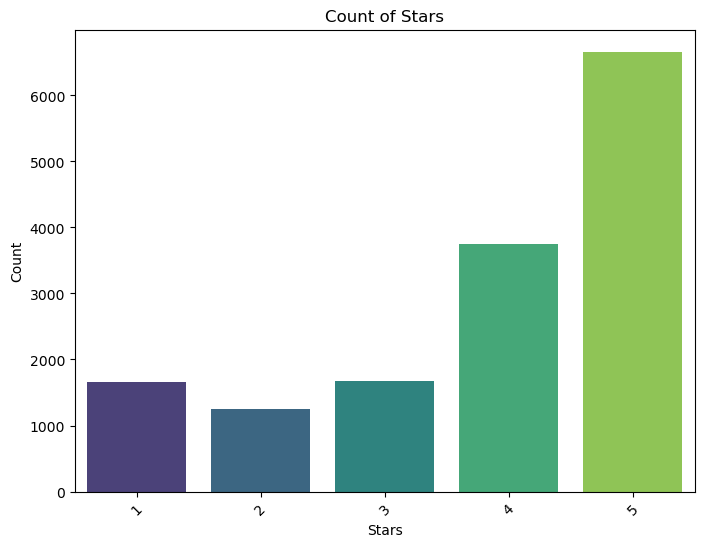

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=df1, palette='viridis')
plt.title('Count of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Hence, we extract equal number of rows for each star for training

C:\Users\yauju\AppData\Local\Temp\ipykernel_24356\3412981758.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df2, palette='viridis')


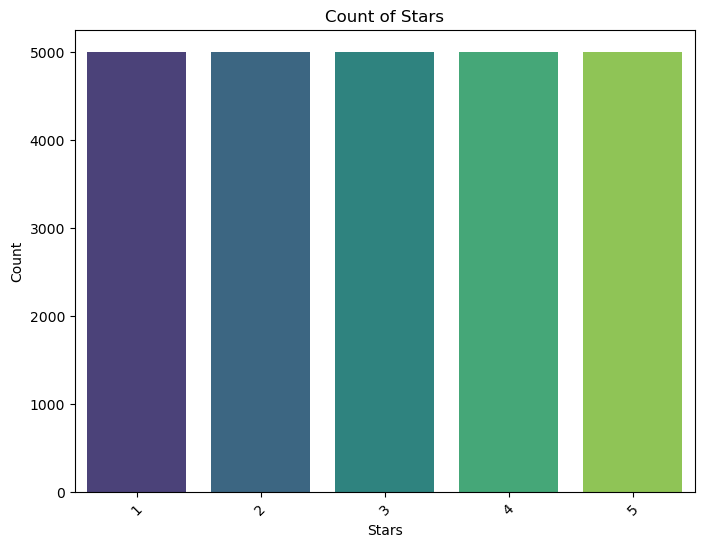

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=df2, palette='viridis')
plt.title('Count of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Data Cleaning

In [17]:
df = df2.copy()

In [20]:
df.duplicated().sum()

0

In [19]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [21]:
df['stars'] = df['stars']-1
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['stars'], test_size=0.2, random_state=42)

## Model

base model class

In [26]:
class DistilGPT2ForBinaryClassification(GPT2Model):
    def __init__(self, num_labels):
        config = AutoConfig.from_pretrained("distilgpt2")
        super().__init__(config)
        self.distil_gpt2 = GPT2Model.from_pretrained("distilgpt2", config=config)
        self.classifier = nn.Linear(config.n_embd, 1)

        self.post_init() 

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs['last_hidden_state'][:,-1,:])
        probabilities = torch.sigmoid(logits)
        return probabilities

In [27]:
class DistilGPT2ForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilGPT2ForSequenceClassification, self).__init__()

         # Load the saved model
        self.distil_gpt2 = DistilGPT2ForBinaryClassification.from_pretrained("./saved_model/model_distilgpt2/")
        # modify the last layer
        self.distil_gpt2.classifier = nn.Linear(self.distil_gpt2.config.hidden_size, num_labels)

        # # Optional: Freeze the model weight except for the last layer
        # for param in self.distil_gpt2.parameters():
        #     param.requires_grad = False
        # for param in self.distil_gpt2.classifier.parameters():
        #     param.requires_grad = True
            
    def forward(self, input_ids, attention_mask=None):
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)
        return outputs

In [28]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [30]:
model = DistilGPT2ForSequenceClassification(5)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# CrossEntropyLoss for multiclass classification
def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, sentiments)
        
        # Accumulate the loss
        train_loss += loss.item()
        
        # Calculate accuracy
        predicted_classes = outputs.argmax(dim=1)
        correct_predictions += (predicted_classes == sentiments).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions / len(data_loader.dataset), train_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, sentiments)
            
            test_loss += loss.item() 
            predicted_classes = outputs.argmax(dim=1)
            correct_predictions += (predicted_classes == sentiments).sum().item()
        
    return correct_predictions / len(data_loader.dataset), test_loss / len(data_loader)

In [34]:
EPOCHS = 3

times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss: {test_loss}, accuracy: {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [16:07<00:00,  1.55s/it]


Train loss: 1.3001896812438964, accuracy: 0.4495
Test loss: 1.251974666953846, accuracy: 0.483
time taken: 1040.3853375911713
Epoch 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [16:22<00:00,  1.57s/it]


Train loss: 1.236897894859314, accuracy: 0.5151
Test loss: 1.2353258003854448, accuracy: 0.5108
time taken: 1056.0877394676208
Epoch 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [16:22<00:00,  1.57s/it]


Train loss: 1.2170917098999023, accuracy: 0.5412
Test loss: 1.229668904261984, accuracy: 0.518
time taken: 1055.9342453479767


In [60]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get predicted classes
        predicted_classes = outputs.argmax(dim=1).cpu().numpy()
        
        # Extend lists with predictions and true values
        y_pred.extend(predicted_classes)
        y_true.extend(sentiments.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.12      0.20      1014
           1       0.39      0.76      0.51       965
           2       0.56      0.48      0.52      1038
           3       0.51      0.49      0.50       973
           4       0.68      0.75      0.71      1010

    accuracy                           0.52      5000
   macro avg       0.59      0.52      0.49      5000
weighted avg       0.59      0.52      0.49      5000



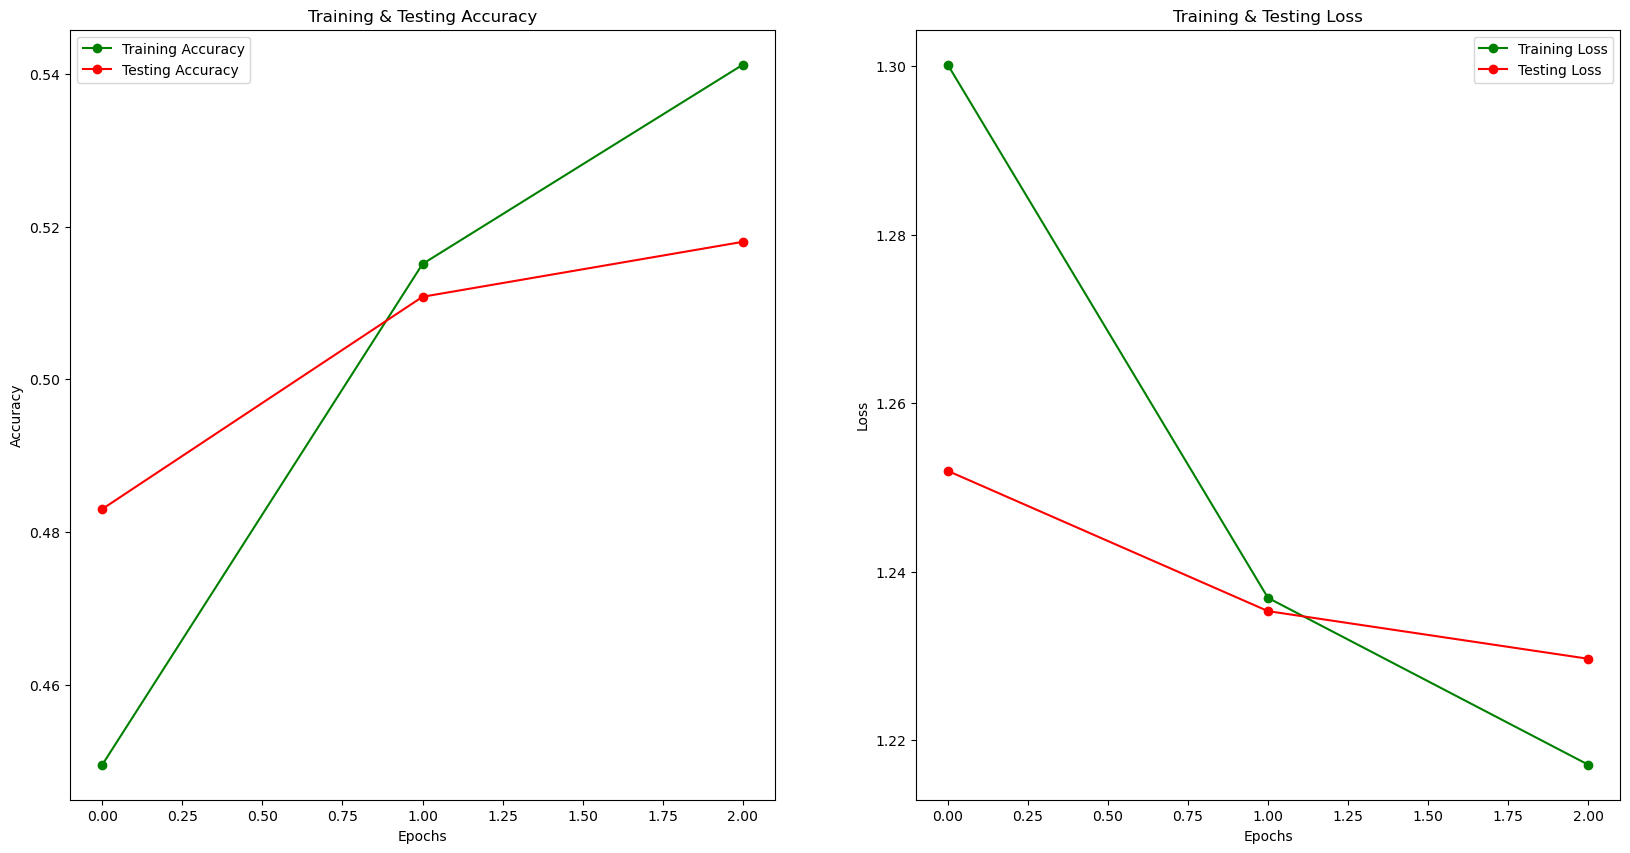

In [61]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [62]:
print(f'train_accs: {train_accs}')
print(f'test_accs: {test_accs}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.4495, 0.5151, 0.5412]
test_accs: [0.483, 0.5108, 0.518]
train_losses: [1.3001896812438964, 1.236897894859314, 1.2170917098999023]
test_losses: [1.251974666953846, 1.2353258003854448, 1.229668904261984]


Text(95.72222222222221, 0.5, 'Actual')

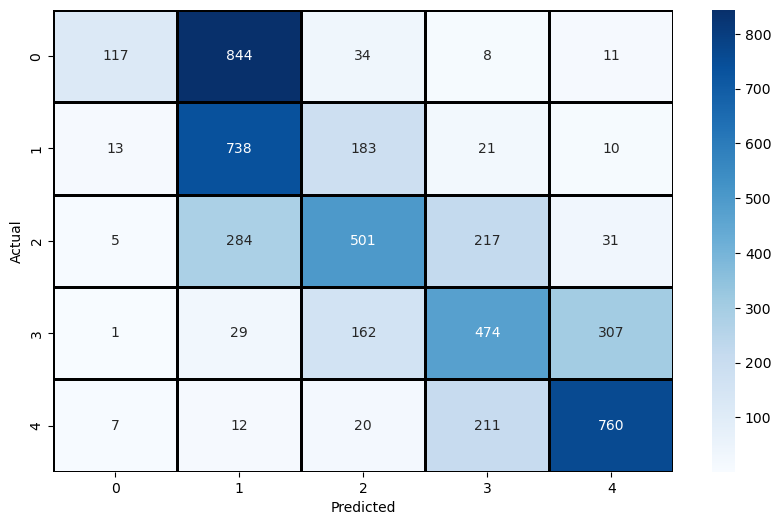

In [63]:
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = [i for i in range(5)] , yticklabels = [i for i in range(5)])
plt.xlabel("Predicted")
plt.ylabel("Actual")

Bad at predicting low star ratings